# First order (Euler - Godunov) Non Linear FV Shallow Water model

* [Riemann solvers](#solver)
* [Interface flux functions](#flux)
* [Boundary conditions](#bcs)
* [dt step](#setdt)
* [Driver function](#iterate)

[Verification: 1D Dambreak](#case1)
* [Data](#c1-data)
* [Simulation with closed boundaries](#c1-sim_closed)
* [Simulation with open boundaries](#c1-sim_open)

[Conclusions](#conclusions)
* [SurfWB-UC results](#surfwb-uc_results)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<a id="solver"> </a>
## Riemann solvers

The one I originally programed at the beginning of the project 

In [2]:
%%writefile nswe1.py 

import numpy as np
g = 9.81
def roe(hl,hul,hr,hur,i=None):
    """
        El solver de roe del paper de Marche (2006?)
    """
    if np.isnan(hl) or np.isnan(hr):
        if not i : 
            print hl,hr
        else:
            print i,hl,hr,'nan'

    ul = 0
    if hl>0: ul = hul/hl
    
    ur = 0
    if hr>0: ur = hur/hr
        
    wl1 = ul - 2*np.sqrt(g*hl)
    wl2 = ul + 2*np.sqrt(g*hl)

    wr1 = ur - 2*np.sqrt(g*hr)
    wr2 = ur + 2*np.sqrt(g*hr)

    uhat = 0.5*(ul+ur)
    hhat = 0.25*(np.sqrt(hl) + np.sqrt(hr))**2

    l1 = uhat - np.sqrt(g*hhat)
    l2 = uhat + np.sqrt(g*hhat)
    l1l = ul - np.sqrt(g*hl)
    l2l = ul + np.sqrt(g*hl)
    l1r = ur - np.sqrt(g*hr)
    l2r = ur + np.sqrt(g*hr)    
  
    #entropy fix programado en el surfwb-uc
    if l1>0:
        ws1 = wl1
        ws2 = wl2
    else:
        ws1 = wr1        
        if l2>0:
            ws2 = wl2
        else:
            ws2 = wr2

    us = 0.5*(ws1+ws2)
    hs = (ws2-ws1)**2/(16.*g)
    
    #entropy fix de marche
    if l1l<0 and l1r > 0:
        us = uhat
        hs = hhat
        
    if l2l<0 and l2r > 0:
        us = uhat
        hs = hhat
    if np.sqrt(hs*g) <= kappa:
        hs = kappa
        us = 0.0        
    return hs,us

Overwriting nswe1.py


A copy from the code of Marche, version 1.1.2 (26 novembre 2008)

In [3]:
%%writefile nswe1.py -a

import numpy as np
g = 9.81
def roe_surf(hl,hul,hr,hur, i=None):
    """
        El solver de roe del paper de Marche (2006?)
    """
    kappa = 1e-4
    if hl<0 or hr<0:
        if not i : 
            print hl,hr
        else:
            print i,hl,hr
    if np.isnan(hl) or np.isnan(hr):
        if not i : 
            print hl,hr
        else:
            print i,hl,hr,'nan'
    cl = np.sqrt(g*hl)
    ul = 0
    if hl>0: ul = hul/hl
    
    cr = np.sqrt(g*hr)
    ur = 0
    if hr>0: ur = hur/hr
        
    cm = 0.5*(cl + cr)
    um = 0.5*(ul + ur)
    
    lambda1 = um - cm
    lambda3 = um + cm
    
    cs = 0.0
    us = 0.0
    if hl > kappa or hr > kappa:
        if lambda1 > 0.0:
            cs = cl
            us = ul
        elif lambda3 < 0.0:
            cs = cr
            us = ur
        else:
            cs = cm - 0.25*(ur-ul)
            us = um  -(cr-cl)
        
        #entropy fix
        if ul - cl < 0 and ur - cr > 0 :
            cs = 0.5*(cl + cr)
            us = 0.5*(ul + ur)
        if ul + cl < 0 and ur + cr > 0 :
            cs = 0.5*(cl + cr)
            us = 0.5*(ul + ur)
        
    #detect dry middle state
    if cs <= kappa:
        hs = kappa
        us = 0.0
    else:
        hs = cs**2/g
        
    return hs,us

Appending to nswe1.py


A verion that is in the middle between both of them. They are mathematically the same, but with slightly different programming

In [4]:
%%writefile nswe1.py -a

import numpy as np
g = 9.81
def roe1(hl,hul,hr,hur,i=None):
    """
        El solver de roe del paper de Marche (2006?)
    """
    kappa = 1e-10
    if hl<0 or hr<0:
        if not i : 
            print hl,hr
        else:
            print i,hl,hr
    ul = 0
    if hl>0: ul = hul/hl
    
    ur = 0
    if hr>0: ur = hur/hr
        
    wl1 = ul - 2*np.sqrt(g*hl)
    wl2 = ul + 2*np.sqrt(g*hl)

    wr1 = ur - 2*np.sqrt(g*hr)
    wr2 = ur + 2*np.sqrt(g*hr)

    uhat = 0.5*(ul+ur)
    hhat = 0.25*(np.sqrt(hl) + np.sqrt(hr))**2

    l1 = uhat - np.sqrt(g*hhat)
    l2 = uhat + np.sqrt(g*hhat)

    ws1 = 0.0
    ws2 = 0.0
    hs = 0.0
    us = 0.0
    if hl>kappa or hr>kappa:
        if l1>0:
            us = ul
            hs = hl
        elif l2<0:
            us = ur
            hs = hr
        else:
            ws1 = wr1    
            ws2 = wl2
            us = 0.5*(ws1+ws2)
            hs = (ws2-ws1)**2/(16.*g)
    
    #entropy fix de marche
    if ul - np.sqrt(g*hl)<0 and ur - np.sqrt(g*hr) > 0:
        us = uhat
        hs = hhat
        
    if ul + np.sqrt(g*hl)<0 and ur + np.sqrt(g*hr)    > 0:
        us = uhat
        hs = hhat
    return hs,us

Appending to nswe1.py


<a id="flux"> </a>

# Interface flux functions

In [5]:
%%writefile nswe1.py -a

def flux(h,u):
    """
        h,u escalares, returna F(U)
    """
    return np.array([h*u, 0.5*g*h*h + h*u*u])

Appending to nswe1.py


<a id="interflux"></a>

$f_i$ es the flux between cells $i$ and $i+1$

In [6]:
%%writefile nswe1.py -a

def fluxes_matrix(h,hu,n,riemann_solver):
    """
        Receives full matrices h,hu (nt,nx)
        including ghost cells   and calculates returns
        fluxes for inner cells  interfaces in row of index n
    """
    nx = h.shape[1]
    f = np.zeros((2,nx-1))
    for i in range(nx-1):
        hs,us = riemann_solver(h[n,i],hu[n,i],h[n,i+1],hu[n,i+1],i)
        f[:,i] = flux(hs,us)
    return f

Appending to nswe1.py


In [7]:
%%writefile nswe1.py -a

def fluxes_row(h0,hu0,nx):
    """
        Like fluxes0, but for a given row 
        h0, hu0 of size (nx,).
    """
    f = np.zeros((2,nx-1))
    for i in range(nx-1):
        hs,us = roe(h0[i],hu0[i],h0[i+1],hu0[i+1])
        f[:,i] = flux(hs,us)
    return f

Appending to nswe1.py


<a id="bcs"> </a>
## Boundary conditions

In [8]:
%%writefile nswe1.py -a

def bcs_closed(h,hu,n):
    """ 
        Applies first order "closed" boundary
        conditions to ghost cells of row n of h and hu. 
        This is, homogeneous Neumann and Dirichlet for h and hu
        respectively
    """
    hb = 1.*h
    hub = 1.*hu
    hb[n,0] = h[n,1]
    hub[n,0] = -hu[n,1]
    hb[n,-1] = h[n,-2]
    hub[n,-1] = -hu[n,-2]    
    return hb,hub

Appending to nswe1.py


In [9]:
%%writefile nswe1.py -a

def bcs_open(h,hu,n):
    """ 
        Applies first order "open" boundary
        conditions on row n of h and hu. 
        This is, homogeneous Neumann for h and hu
        respectively
    """
    hb = 1.*h
    hub = 1.*hu
    hb[n,0] = h[n,1]
    hub[n,0] = hu[n,1]
    hb[n,-1] = h[n,-2]
    hub[n,-1] = hu[n,-2]    
    return hb,hub

Appending to nswe1.py


<a id="setdt"></a>
## $\Delta t$ step

In [10]:
%%writefile nswe1.py -a

def setdt(h,hu,n,dx,cfl):
    """
        Calcula el dt segun condicion de CFL
    """
    u_n = np.where(h[n,:]>1e-5, hu[n,:]/h[n,:], 0.)
    s = np.max(np.abs(u_n)+np.sqrt(9.81*h[n,:]))
    dt = cfl*dx/np.max(s)
    return dt

Appending to nswe1.py


<a id="iterate"></a>
## Simulation main function

In [11]:
%%writefile nswe1.py -a

def simulate(h,hu,bcs,dx,cfl,t0,nt,riemann_solver):
    """
        Rutina principal que corre la simulacion
    """
    t = np.zeros((nt,))
    for n in range(nt-1):     
        dt = setdt(h,hu,n,dx,cfl)
        
        t[n+1] = t[n] + dt

        h,hu = bcs(h,hu,n)    
        f = fluxes_matrix(h,hu,n,riemann_solver)

        h[n+1,1:-1] = h[n,1:-1] -dt/dx*(f[0,1:]-f[0,:-1])
        hu[n+1,1:-1] = hu[n,1:-1] -dt/dx*(f[1,1:]-f[1,:-1])   
        
    return t,h,hu

Appending to nswe1.py


<a id="case1"></a>
# Verification

## 1D Dam break

<a id="c1-data"></a>
## Geometry and initial condition 

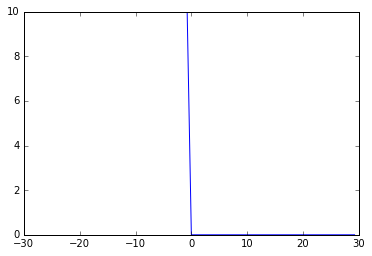

In [12]:
L = 30.
npoints = 40
dx = L/npoints
x = np.arange(-L,L,dx)
dx = np.min(np.diff(x))
nx = x.shape[0]
cfl = 0.45
t0  = 0.
nt = 150

h = np.zeros((nt,x.shape[0]))
hu = np.zeros((nt,x.shape[0]))
h[0,:] = np.where(x<0.0, 10., 0.0)
hu[0,:] = 0.

plt.plot(x,h[0,:])


<a id="c1-sim_closed"></a>
## Simulation using closed boundaries

In [13]:
import nswe1
tSurf,hSurf,huSurf = nswe1.simulate(h,hu,nswe1.bcs_closed,dx,cfl,t0,nt,nswe1.roe_surf)

nswe1.py:237: RuntimeWarning: invalid value encountered in divide
  u_n = np.where(h[n,:]>1e-5, hu[n,:]/h[n,:], 0.)
nswe1.py:238: RuntimeWarning: invalid value encountered in sqrt
  s = np.max(np.abs(u_n)+np.sqrt(9.81*h[n,:]))


77 0.000264703924801 -3.04105195124e-06
78 -3.04105195124e-06 -3.04105195124e-06
nan nan
1 nan nan nan
2 nan nan nan
3 nan nan nan
4 nan nan nan
5 nan nan nan
6 nan nan nan
7 nan nan nan
8 nan nan nan
9 nan nan nan
10 nan nan nan
11 nan nan nan
12 nan nan nan
13 nan nan nan
14 nan nan nan
15 nan nan nan
16 nan nan nan
17 nan nan nan
18 nan nan nan
19 nan nan nan
20 nan nan nan
21 nan nan nan
22 nan nan nan
23 nan nan nan
24 nan nan nan
25 nan nan nan
26 nan nan nan
27 nan nan nan
28 nan nan nan
29 nan nan nan
30 nan nan nan
31 nan nan nan
32 nan nan nan
33 nan nan nan
34 nan nan nan
35 nan nan nan
36 nan nan nan
37 nan nan nan
38 nan nan nan
39 nan nan nan
40 nan nan nan
41 nan nan nan
42 nan nan nan
43 nan nan nan
44 nan nan nan
45 nan nan nan
46 nan nan nan
47 nan nan nan
48 nan nan nan
49 nan nan nan
50 nan nan nan
51 nan nan nan
52 nan nan nan
53 nan nan nan
54 nan nan nan
55 nan nan nan
56 nan nan nan
57 nan nan nan
58 nan nan nan
59 nan nan nan
60 nan nan nan
61 nan nan nan
62 na

nswe1.py:83: RuntimeWarning: invalid value encountered in sqrt
  cr = np.sqrt(g*hr)
nswe1.py:79: RuntimeWarning: invalid value encountered in sqrt
  cl = np.sqrt(g*hl)
nswe1.py:237: RuntimeWarning: invalid value encountered in greater
  u_n = np.where(h[n,:]>1e-5, hu[n,:]/h[n,:], 0.)


In [14]:
t,h,hu = nswe1.simulate(h,hu,nswe1.bcs_closed,dx,cfl,t0,nt,nswe1.roe1)

77 0.0502243149206 -0.0502243031208
78 -0.0502243031208 -0.0502243031208


nswe1.py:143: RuntimeWarning: invalid value encountered in sqrt
  wr1 = ur - 2*np.sqrt(g*hr)
nswe1.py:144: RuntimeWarning: invalid value encountered in sqrt
  wr2 = ur + 2*np.sqrt(g*hr)
nswe1.py:147: RuntimeWarning: invalid value encountered in sqrt
  hhat = 0.25*(np.sqrt(hl) + np.sqrt(hr))**2
nswe1.py:170: RuntimeWarning: invalid value encountered in sqrt
  if ul - np.sqrt(g*hl)<0 and ur - np.sqrt(g*hr) > 0:
nswe1.py:174: RuntimeWarning: invalid value encountered in sqrt
  if ul + np.sqrt(g*hl)<0 and ur + np.sqrt(g*hr)    > 0:
nswe1.py:140: RuntimeWarning: invalid value encountered in sqrt
  wl1 = ul - 2*np.sqrt(g*hl)
nswe1.py:141: RuntimeWarning: invalid value encountered in sqrt
  wl2 = ul + 2*np.sqrt(g*hl)


### Animation


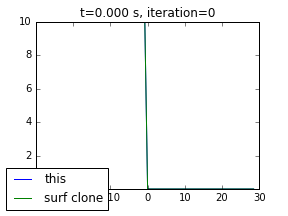
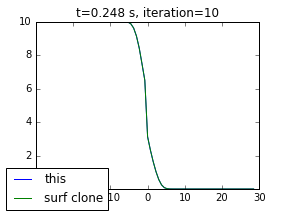
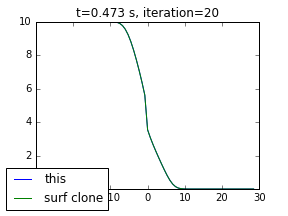
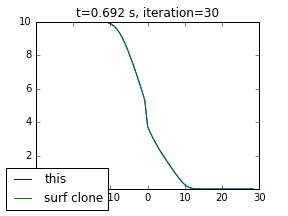
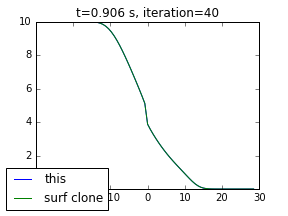
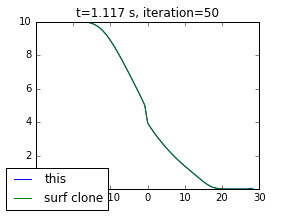
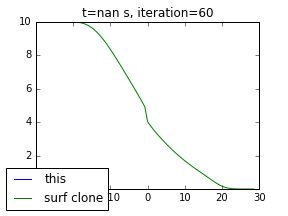
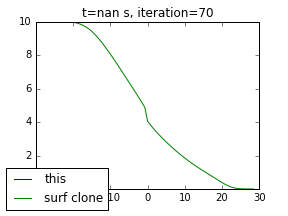
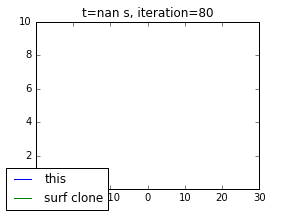
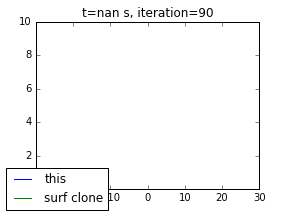
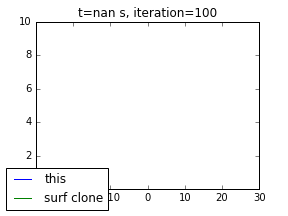
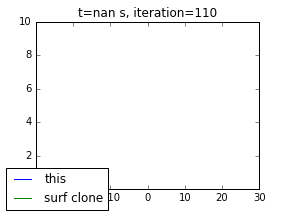
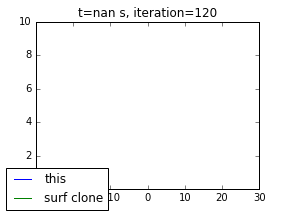
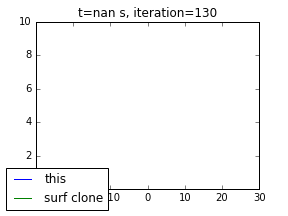
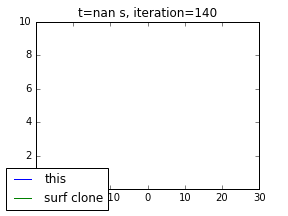

In [15]:
from JSAnimation import IPython_display
from matplotlib import animation
f1 = plt.figure(figsize=(4.,3))
ax1 = f1.add_subplot(111)
lh, = ax1.plot(x[1:-1],h[0,1:-1])
lhsurf, = ax1.plot(x[1:-1],hSurf[0,1:-1])
ax1.set_ylim(0,10)
f1.legend((lh,lhsurf),['this','surf clone'],loc='lower left')


def animate(i):
    i=min(i*10,h.shape[0]-1)
    lh.set_ydata(h[i,1:-1])
    lhsurf.set_ydata(hSurf[i,1:-1])
    ax1.set_title('t=%.3f s, iteration=%i'%(t[i],i))
animation.FuncAnimation(f1,animate,frames=range(nt/10))

<a id="c1-sim_open"></a>
## Simulation using open boundaries

In [16]:
tSurfOpen,hSurfOpen,huSurfOpen = nswe1.simulate(h,hu,nswe1.bcs_open,dx,cfl,t0,nt,nswe1.roe_surf)

nan nan
1 nan nan nan
2 nan nan nan
3 nan nan nan
4 nan nan nan
5 nan nan nan
6 nan nan nan
7 nan nan nan
8 nan nan nan
9 nan nan nan
10 nan nan nan
11 nan nan nan
12 nan nan nan
13 nan nan nan
14 nan nan nan
15 nan nan nan
16 nan nan nan
17 nan nan nan
18 nan nan nan
19 nan nan nan
20 nan nan nan
21 nan nan nan
22 nan nan nan
23 nan nan nan
24 nan nan nan
25 nan nan nan
26 nan nan nan
27 nan nan nan
28 nan nan nan
29 nan nan nan
30 nan nan nan
31 nan nan nan
32 nan nan nan
33 nan nan nan
34 nan nan nan
35 nan nan nan
36 nan nan nan
37 nan nan nan
38 nan nan nan
39 nan nan nan
40 nan nan nan
41 nan nan nan
42 nan nan nan
43 nan nan nan
44 nan nan nan
45 nan nan nan
46 nan nan nan
47 nan nan nan
48 nan nan nan
49 nan nan nan
50 nan nan nan
51 nan nan nan
52 nan nan nan
53 nan nan nan
54 nan nan nan
55 nan nan nan
56 nan nan nan
57 nan nan nan
58 nan nan nan
59 nan nan nan
60 nan nan nan
61 nan nan nan
62 nan nan nan
63 nan nan nan
64 nan nan nan
65 nan nan nan
66 nan nan nan
67 nan nan 

In [17]:
tOpen,hOpen,huOpen = nswe1.simulate(h,hu,nswe1.bcs_open,dx,cfl,t0,nt,nswe1.roe1)

### Animation


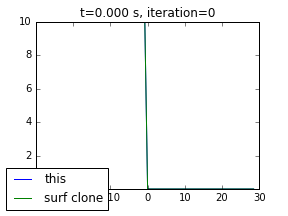
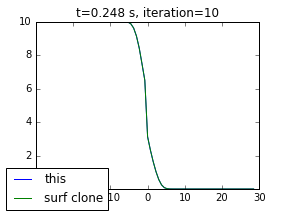
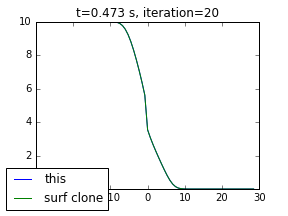
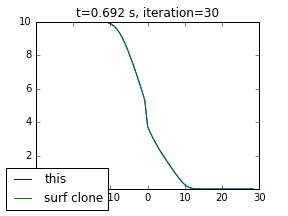
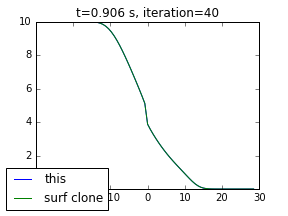
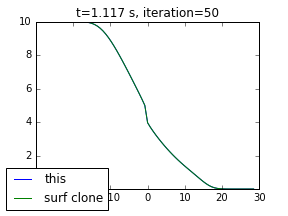
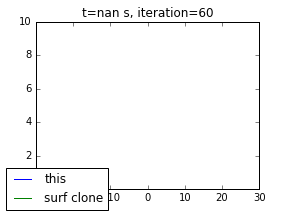
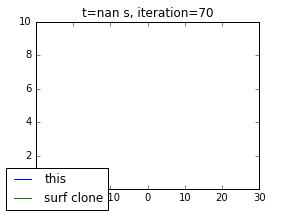
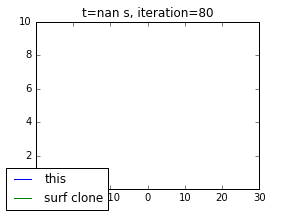
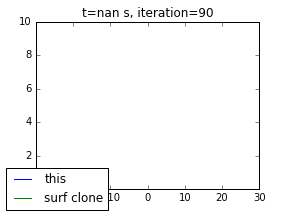
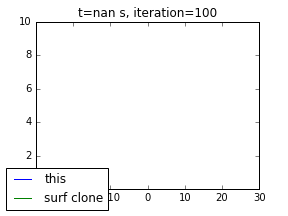
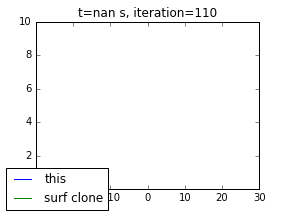
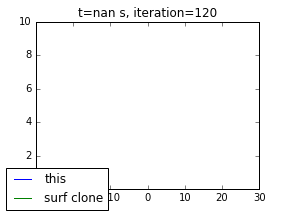
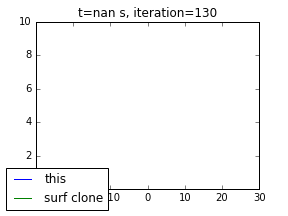
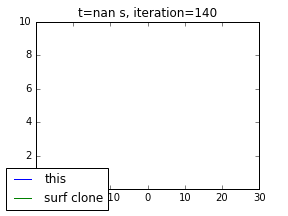

In [18]:
from JSAnimation import IPython_display
from matplotlib import animation
f1 = plt.figure(figsize=(4.,3))
ax1 = f1.add_subplot(111)
lh, = ax1.plot(x[1:-1],hOpen[0,1:-1])
lhsurf, = ax1.plot(x[1:-1],hSurfOpen[0,1:-1])
ax1.set_ylim(0,10)
f1.legend((lh,lhsurf),['this','surf clone'],loc='lower left')


def animate(i):
    i=min(i*10,h.shape[0]-1)
    lh.set_ydata(hOpen[i,1:-1])
    lhsurf.set_ydata(hSurfOpen[i,1:-1])
    ax1.set_title('t=%.3f s, iteration=%i'%(t[i],i))
animation.FuncAnimation(f1,animate,frames=range(nt/10))

## Same dambreak, domain twice as large

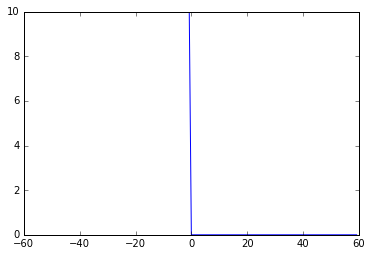

In [19]:
x2L = np.arange(-2*L,2*L,dx)
nx = x.shape[0]


h = np.zeros((nt,x2L.shape[0]))
hu = np.zeros((nt,x2L.shape[0]))
h[0,:] = np.where(x2L<0.0, 10., 0.0)
hu[0,:] = 0.

plt.plot(x2L,h[0,:])

In [20]:
tSurf_2L,hSurf_2L,huSurf_2L = nswe1.simulate(h,hu,nswe1.bcs_closed,dx,cfl,t0,nt,nswe1.roe_surf)


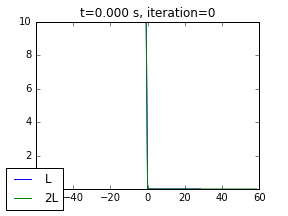
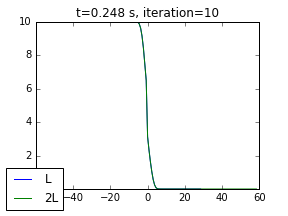
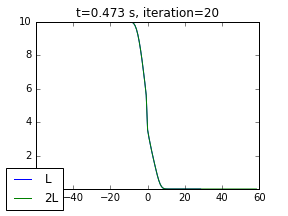
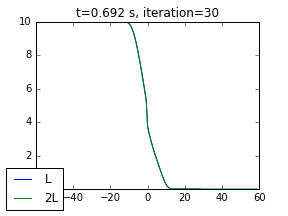
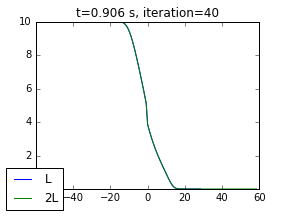
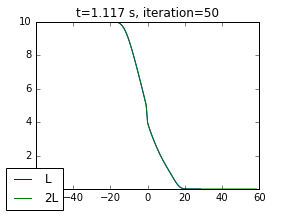
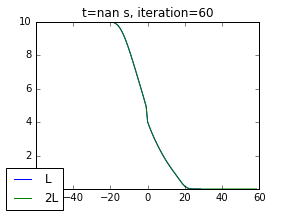
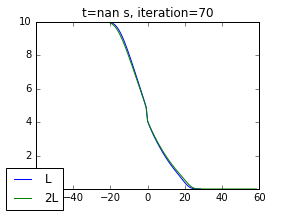
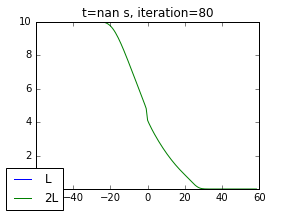
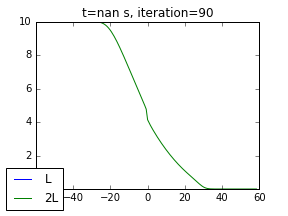
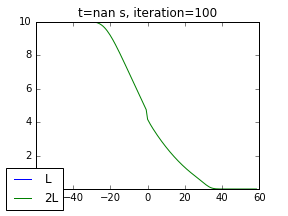
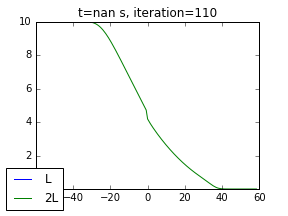
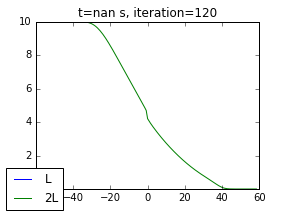
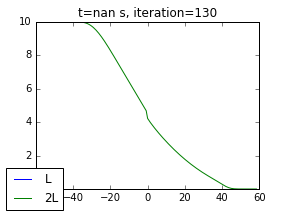
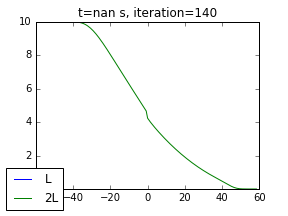

In [21]:
from JSAnimation import IPython_display
from matplotlib import animation
f1 = plt.figure(figsize=(4.,3))
ax1 = f1.add_subplot(111)
lhL, = ax1.plot(x[1:-1],hSurf[0,1:-1])
lh2L, = ax1.plot(x2L[1:-1],hSurf_2L[0,1:-1])
ax1.set_ylim(0,10)
f1.legend((lh,lhsurf),['L','2L'],loc='lower left')


def animate(i):
    i=min(i*10,h.shape[0]-1)
    lhL.set_ydata(hSurf[i,1:-1])
    lh2L.set_ydata(hSurf_2L[i,1:-1])
    ax1.set_title('t=%.3f s, iteration=%i'%(t[i],i))
animation.FuncAnimation(f1,animate,frames=range(nt/10))

<a id="conclusions"></a>
# Conclusions

* Both solvers (fortran surfwb (marche) code and mine) are the same! (finally)...suggests no bugs
* The small jump in the interface is also observed in the SURFWB-UC, see image below
* There are errors from the boundary when using closed boundaries. These errors are also observed in SurfWB-UC (with order 2)
* Those errors no longer appear when using open boundaries

<a id="surfwb-uc_results"></a>
## SurfWB-UC-results

Some fluctuation in the interface, and even in the foot of the wave

<img src=figures/NsweSolvers/surfwb_1dfig000018.png>

It also fails in the boundary

<img src=figures/NsweSolvers/surfwb_1dfig000205.png>

In [50]:
def fk(h,hk):
    if h<=hk:
        return 2.*(np.sqrt(g*h)-np.sqrt(g*hk))
    else:
        return (h-hk)*np.sqrt(1.0/2.0*g*(h+hk)/(h*hk));  
def dfk(h,hk):
    if h<=hk:
        return g/np.sqrt(g*hk)
    else:
        gk = np.sqrt(0.5*g*(h+hk)/(h*hk))
        return gk-g*(h-hk)/(4*h*h*gk)   

In [51]:
from scipy.optimize import fsolve

In [52]:
def solveNewton(hl,ul,hr,ur):
    h0=1./g*(0.5*(np.sqrt(hl*g)+np.sqrt(hr*g))-0.25*(ur-ul))**2
    f = lambda h: fk(h,hl)-fk(h,hr)+ur-ul
    hstar = fsolve(f,h0)[0]
    return hstar

In [59]:
g = 9.81
solveNewton(10.,0.0,1.0,0.0)

/home/jose/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()


4.3311388300841891

In [60]:
import dambreak
dambreak.SWAnalyticalSolutionWet(np.array([0.0]),1.0,0.0,10.0,1.0,9.81)

(array([ 4.44444444]), array([ 6.60302961]))

In [ ]:
def solver_exacto(hl,hul,hr,hur,i=None):
    kappa = 1e-5
    if hl<0 or hr<0:
        print hl,hr, ':('
    ul = 0
    if hl>0: ul = hul/hl
    
    ur = 0
    if hr>0: ur = hur/hr
    
    if hl>kappa and hr>kappa:
        